#### 5-fold cross validation: Divide 1/8 of the training set into validation sets (i.e. 70% training set, 10% validation set, 20% test set)

## Cohort 1 (Survival vs. Death)

✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/catboost_gridsearch_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/xgboost_gridsearch_valid_test_5cv/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/randomforest_gridsearch_valid_test_5cv/max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_death_valid_test_5cv/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/seed_1251_all_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/lr_valid_test_5cv/all_folds_results.csv，共 971 条记录


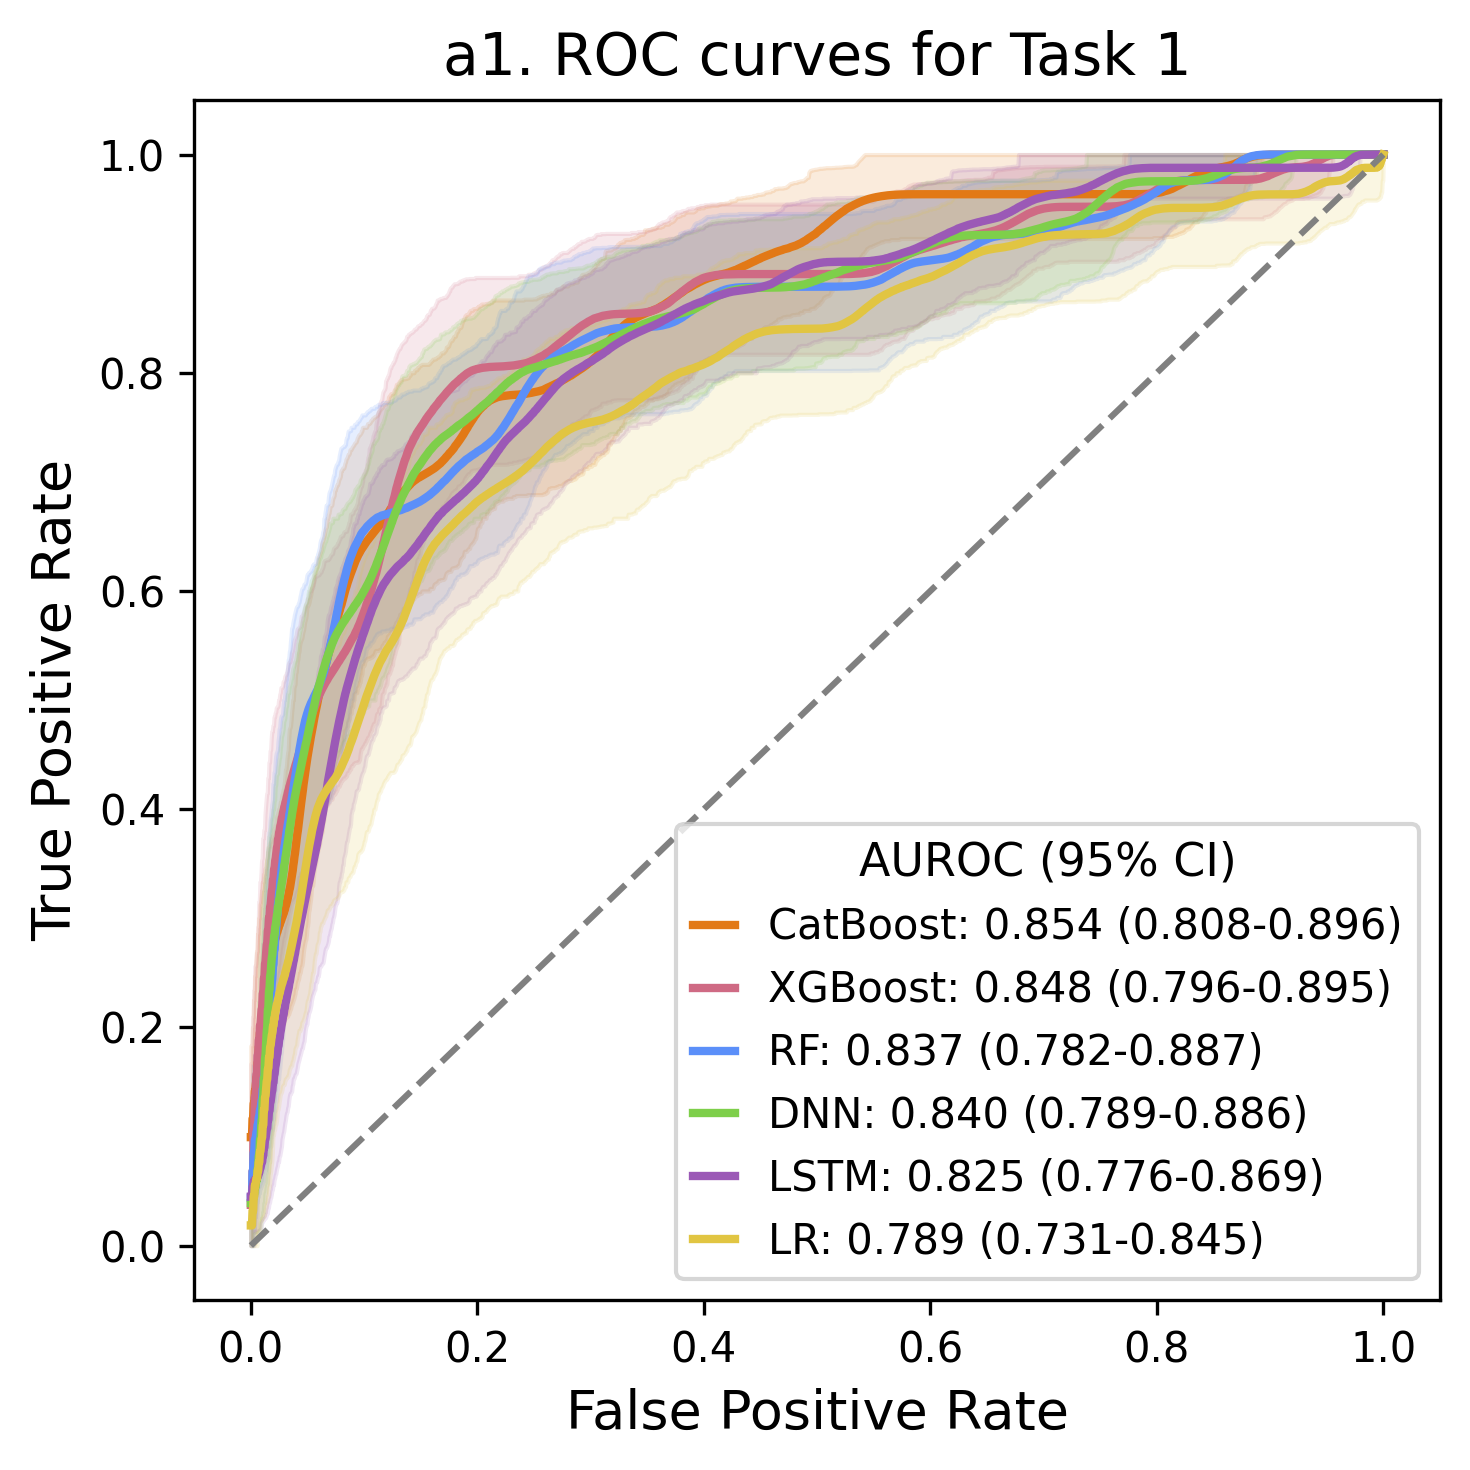

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

title_num = 'a1'

# =========================================================
# Calculate ROC curve + confidence interval
# =========================================================
def get_roc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_fpr = np.linspace(0, 1, 2000)

    bootstrapped_scores = []
    tprs = []

    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]

        fpr, tpr, _ = roc_curve(y_true_boot, y_pred_boot)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        bootstrapped_scores.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    mean_auc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return mean_fpr, mean_tpr, tprs_lower, tprs_upper, mean_auc, ci_lower, ci_upper


# =========================================================
#  parameter defines
# =========================================================

colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]
models = [
          'catboost',
          'xgboost',
          'randomforest',
          'DNN',
          'LSTM',
          'lr',
          ]
labels = [
          'CatBoost',
          'XGBoost',
          'RF',
          'DNN', 
          'LSTM',
          'LR',
          ]



# =========================================================
# drew the ROC curve
# =========================================================
plt.figure(figsize=(5, 5), dpi=300)
# plt.figure(figsize=(5, 5))

for model, color, label in zip(models, colors, labels):
    # file = os.path.join(search_path, model, 'predict_death_valid_test', 'all_folds_results.csv')
    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'seed_1251_all_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## 训练模型时试随机种子
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## 训练模型时试随机种子
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'max_depth_5_n_estimators_200', 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ 未找到文件：{file}")
        continue

    df = pd.read_csv(file)
    print(f"✅ 读取文件：{file}，共 {len(df)} 条记录")
    if not {'y_test', 'y_pred'}.issubset(df.columns):
        raise ValueError(f"{file} 缺少 'y_test' 或 'y_pred' 列")

    # 计算 ROC + CI
    mean_fpr, mean_tpr, tprs_lower, tprs_upper, mean_auc, ci_lower, ci_upper = get_roc_CI_curve(
        df['y_test'], df['y_pred']
    )

    # 绘图
    plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
             label=f"{label}: {mean_auc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=0.15)


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

lg = plt.legend(loc='lower right', handlelength=1.0, fontsize=10, title='AUROC (95% CI)')
lg.get_title().set_fontsize(11)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title(f'{title_num}. ROC curves for Task 1', fontsize=14)
plt.tight_layout()
plt.show()


✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/catboost_gridsearch_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/xgboost_gridsearch_valid_test_5cv/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/randomforest_gridsearch_valid_test_5cv/max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_death_valid_test_5cv/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/seed_1251_all_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death/lr_valid_test_5cv/all_folds_results.csv，共 971 条记录


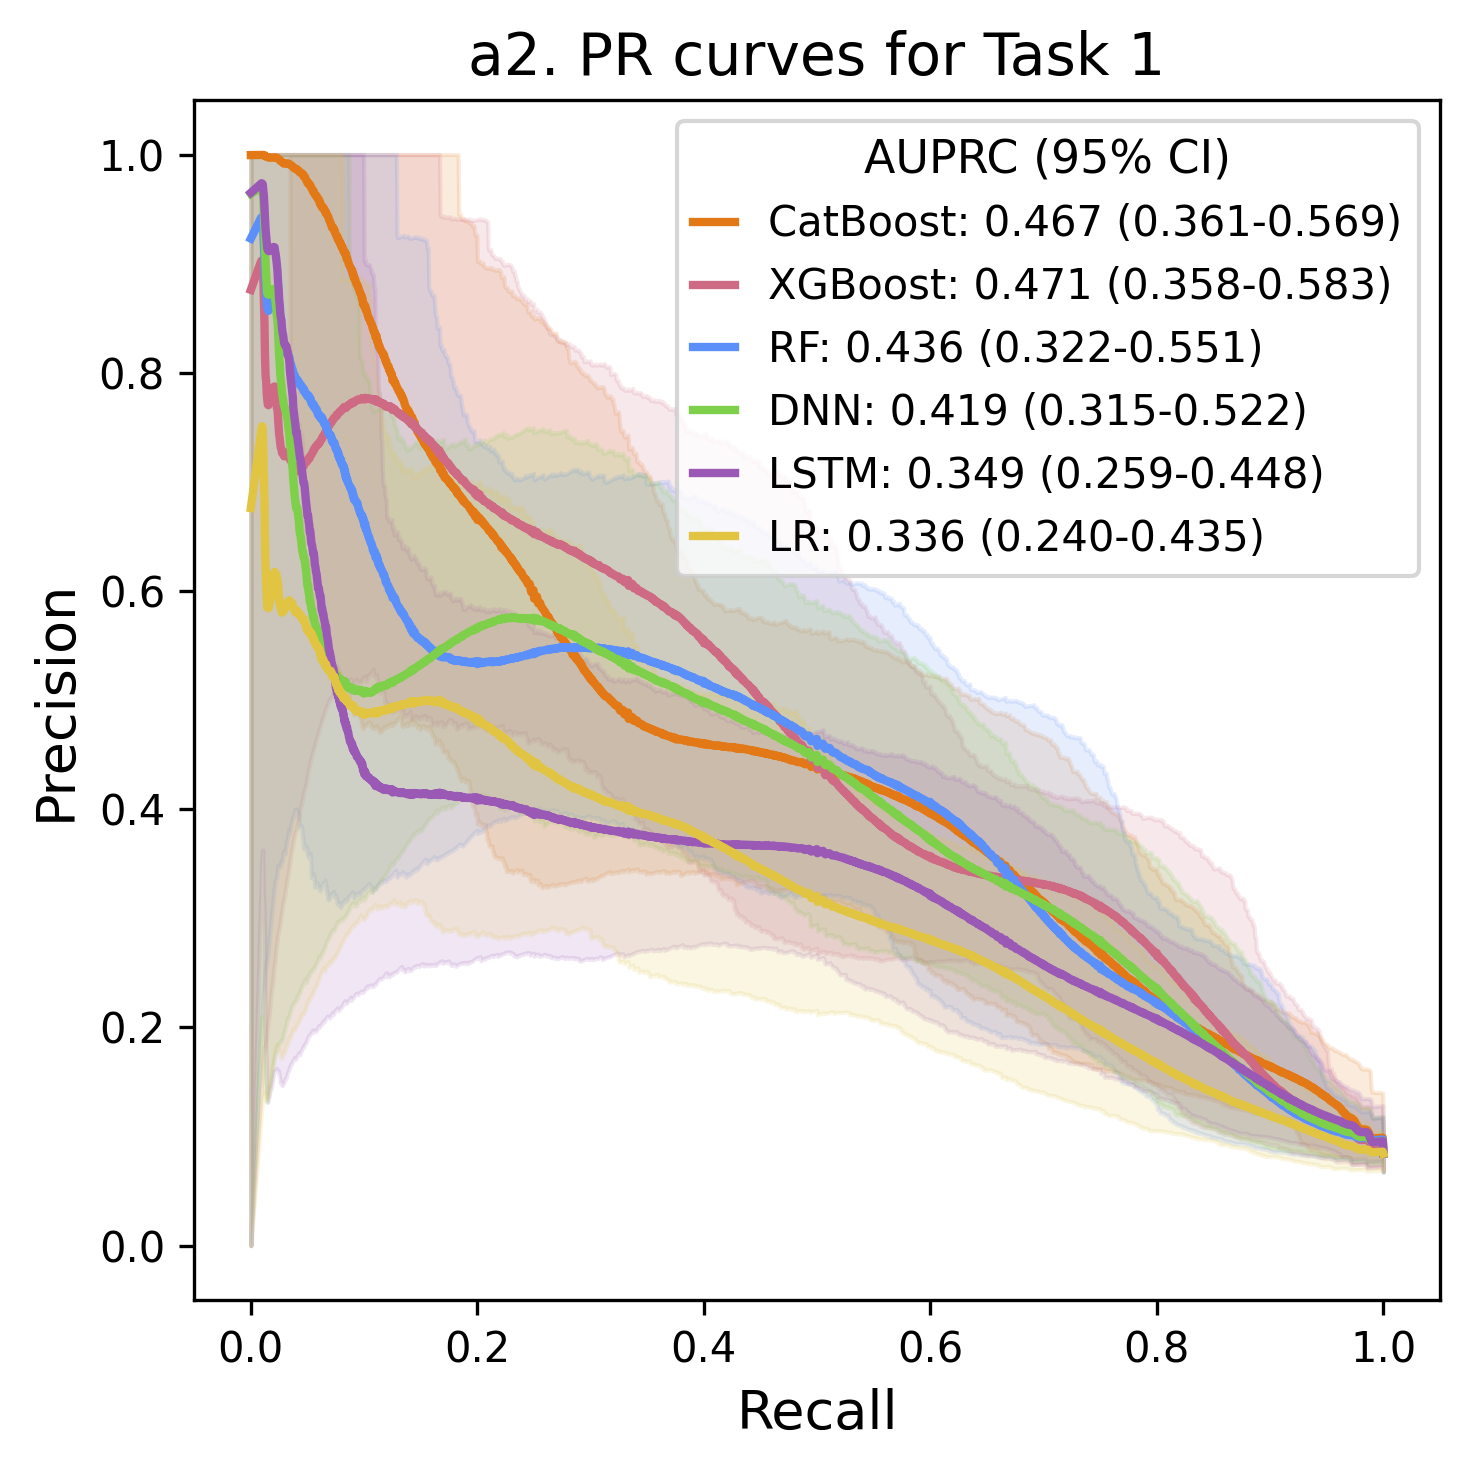

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

title_num = 'a2'

# =========================================================
# Calculate PR curve + confidence interval
# =========================================================
def get_prc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_recall = np.linspace(0, 1, 2000)
    bootstrapped_scores = []
    precisions = []

    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]

        precision, recall, _ = precision_recall_curve(y_true_boot, y_pred_boot)
        # 为了在相同 recall 上插值 precision
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        bootstrapped_scores.append(average_precision_score(y_true_boot, y_pred_boot))

    mean_precision = np.mean(precisions, axis=0)
    precisions_lower = np.percentile(precisions, 2.5, axis=0)
    precisions_upper = np.percentile(precisions, 97.5, axis=0)
    mean_auprc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return mean_recall, mean_precision, precisions_lower, precisions_upper, mean_auprc, ci_lower, ci_upper


# =========================================================
# parameter defines
# =========================================================
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]  # 每个模型对应的颜色
models = [
          'catboost',
          'xgboost',
          'randomforest',
          'DNN',
          'LSTM',
          'lr',
          ]
labels = [
          'CatBoost',
          'XGBoost',
          'RF',
          'DNN', 
          'LSTM',
          'LR',
          ]


# =========================================================
# Draw PRC curve
# =========================================================
# plt.figure(figsize=(5, 5))
plt.figure(figsize=(5, 5), dpi=300)

for model, color, label in zip(models, colors, labels):
    # file = os.path.join(search_path, model, 'predict_death_valid_test', 'all_folds_results.csv')
    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'seed_1251_all_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## 训练模型时试随机种子
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## 训练模型时试随机种子
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
        file = os.path.join(search_path, f'max_depth_5_n_estimators_200', 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ 未找到文件：{file}")
        continue

    df = pd.read_csv(file)
    print(f"✅ 读取文件：{file}，共 {len(df)} 条记录")
    if not {'y_test', 'y_pred'}.issubset(df.columns):
        raise ValueError(f"{file} 缺少 'y_test' 或 'y_pred' 列")

    # 计算 PRC + CI
    mean_recall, mean_precision, precisions_lower, precisions_upper, mean_auprc, ci_lower, ci_upper = get_prc_CI_curve(
        df['y_test'], df['y_pred']
    )

    # 绘图
    plt.plot(mean_recall, mean_precision, color=color, lw=2,
             label=f"{label}: {mean_auprc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
    plt.fill_between(mean_recall, precisions_lower, precisions_upper, color=color, alpha=0.15)

# plt.plot([0, 1], [0.5, 0.5], color='gray', linestyle='--', label='Baseline (0.5)')

lg = plt.legend(loc='upper right', handlelength=1.0, fontsize=10, title='AUPRC (95% CI)')
lg.get_title().set_fontsize(11)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title(f'{title_num}. PR curves for Task 1', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
"""
scale_pos_weight just changes the weight of training loss → model bias positive

Overall high output probability → training set and test set probability distributions do not match true distributions

So Brier scores go up, calibration curves go off.

If the task focuses on probabilistic accuracy (such as decision analysis DCA), it may be better not to use scale_pos_weight, but instead use sample resampling + calibration
"""

✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/xgboost/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/randomforest/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_death_calibration/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_calibration/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/lr/all_folds_results.csv，共 971 条记录


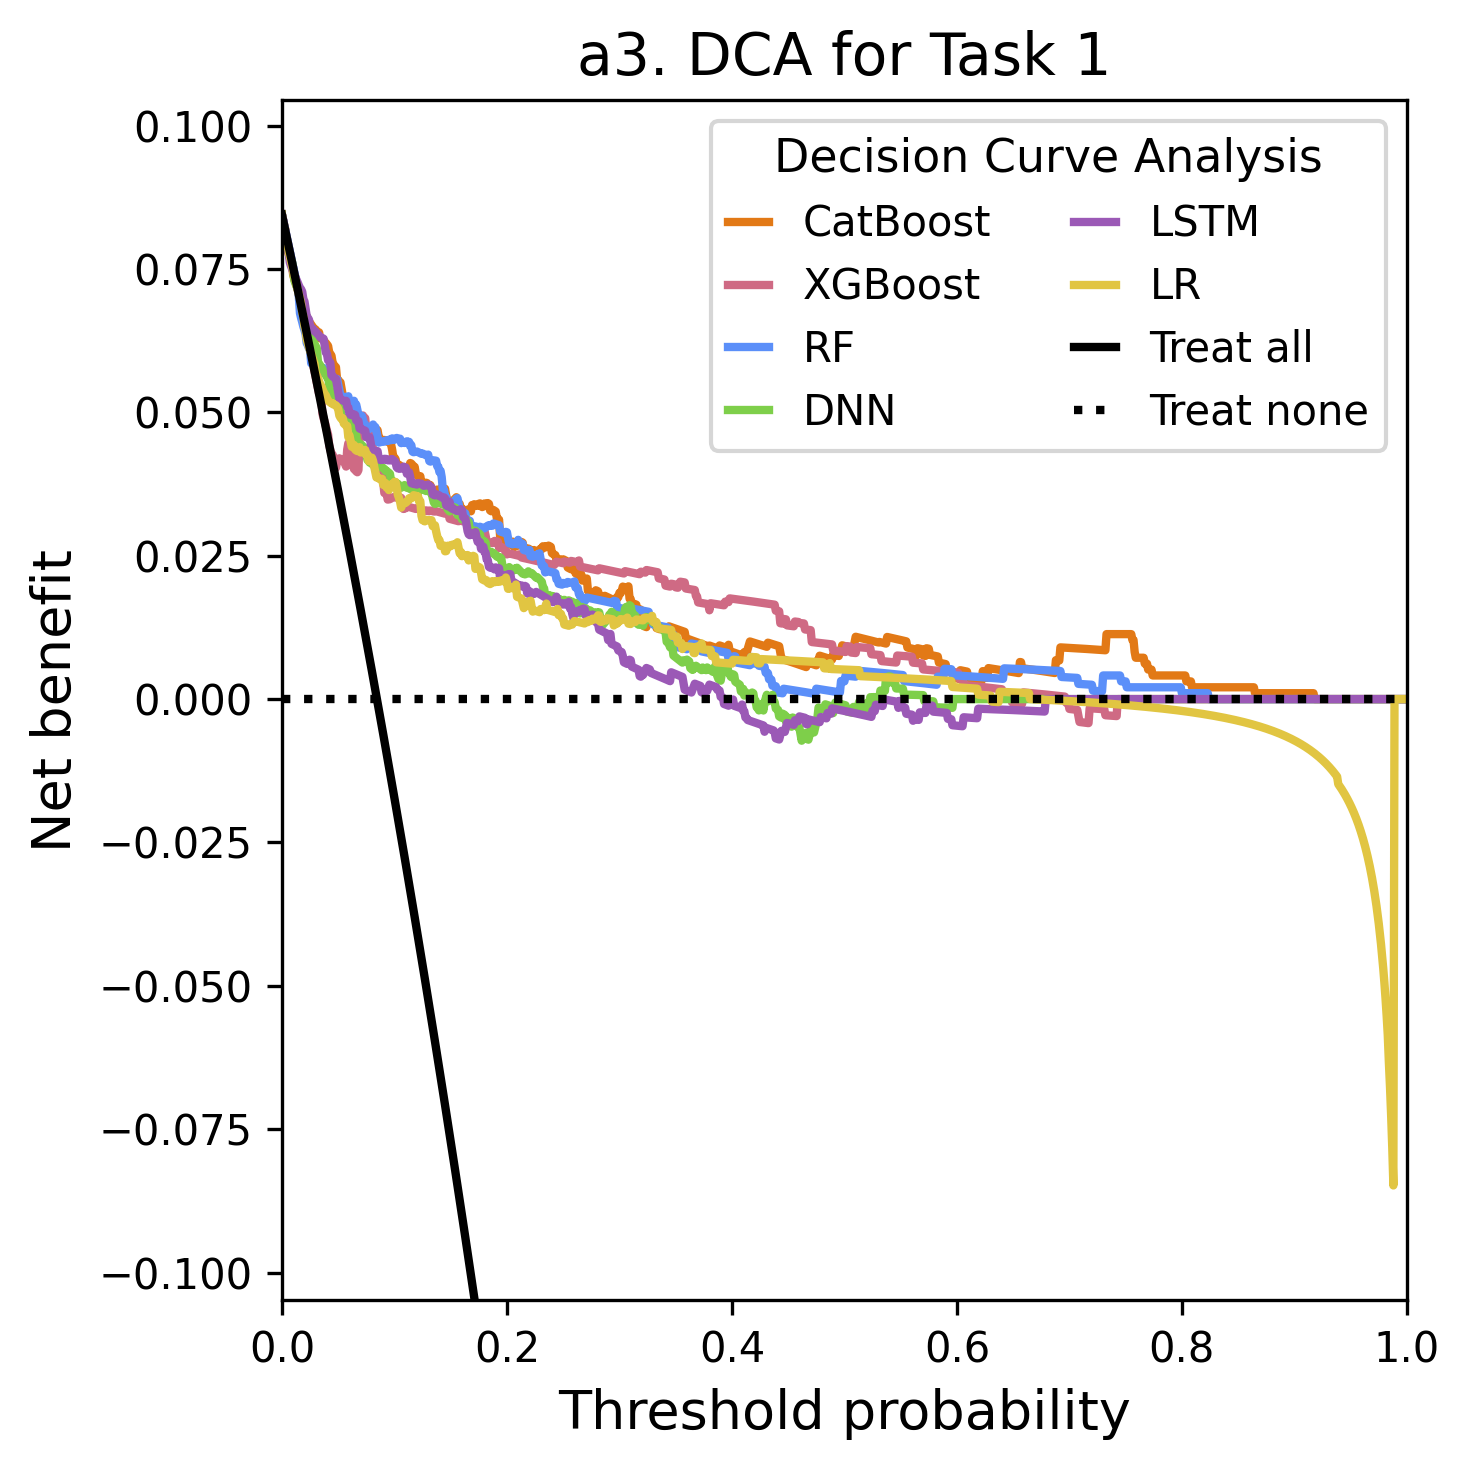

In [ ]:
#####################################
# Decision Curve Analysis (DCA)
#####################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

######################
## decision_curve

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    """Calculate the net benefit of the model at different thresholds"""
    n = len(y_label)
    net_benefit_model = []
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        nb = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model.append(nb)
    return np.array(net_benefit_model)

def calculate_net_benefit_all(thresh_group, y_label):
    """Net benefit of the 'Treat all' strategy"""
    n = len(y_label)
    num_pos = np.sum(y_label == 1)
    num_neg = n - num_pos
    net_benefit_all = []
    for thresh in thresh_group:
        nb = (num_pos / n) - (num_neg / n) * (thresh / (1 - thresh))
        net_benefit_all.append(nb)
    return np.array(net_benefit_all)

def calculate_net_benefit_none(thresh_group, y_label):
    """Net benefit of the 'Treat none' strategy, always 0"""
    return np.zeros_like(thresh_group)

#########

title_num = 'a3'

data = {}
thresh_group = np.arange(0, 1, 0.001)

# Unified image size and resolution
plt.figure(figsize=(5, 5), dpi=300)

# Model list
models = [
          'catboost',
          'xgboost',
          'randomforest',
          'DNN',
          'LSTM',
          'lr',
          ]
labels = [
          'CatBoost',
          'XGBoost',
          'RF',
          'DNN', 
          'LSTM',
          'LR',
          ]

# Curve colors
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]

# Read data
for model in models:

    # if model == 'DNN':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'all_folds_results.csv')
    # elif model == 'LSTM':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'seed_1251_all_results.csv')
    # elif model == 'catboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## Random seed during training
    # elif model == 'xgboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## Random seed during training
    # elif model == 'randomforest':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'max_depth_5_n_estimators_200', 'all_folds_results.csv')
    # elif model == 'lr':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')

    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_calibration', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_calibration', 'all_folds_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## Random seed during training
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## Random seed during training
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue
    df = pd.read_csv(file)
    print(f"✅ File read: {file}, total {len(df)} records")
    data[model] = df

# Plot DCA curves
for c_index, (model, label) in enumerate(zip(models, labels)):
    if model not in data:
        continue
    net_benefit_model = calculate_net_benefit_model(
        thresh_group, 
        data[model]['y_pred'],  # Column name 'y_pred' in AUROC file
        data[model]['y_test']
    )
    plt.plot(
        thresh_group, 
        net_benefit_model, 
        label=label,
        color=colors[c_index], 
        lw=2
    )

# Plot Treat all / Treat none
net_benefit_all = calculate_net_benefit_all(thresh_group, data[model]['y_test'])
net_benefit_none = calculate_net_benefit_none(thresh_group, data[model]['y_test'])
plt.plot(thresh_group, net_benefit_all, color='black', lw=2, label='Treat all')
plt.plot(thresh_group, net_benefit_none, color='black', linestyle=':', lw=2, label='Treat none')

# Axes and font
plt.xlim(0, 1)
plt.ylim(net_benefit_model.min() - 0.02, net_benefit_model.max() + 0.02)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.xlabel('Threshold probability', fontsize=13)
plt.ylabel('Net benefit', fontsize=13)

# Legend
lg = plt.legend(
    loc='upper right',
    handlelength=1.0,
    fontsize=10,
    ncol=2,
    columnspacing=2.0,
    title='Decision Curve Analysis',
)
lg.get_title().set_fontsize(11)

plt.title(
    f'{title_num}. DCA for Task 1',
    fontsize=14
)
plt.tight_layout()
plt.show()


✅ 读取 catboost 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv 共 971 条记录
✅ 读取 xgboost 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/xgboost/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv 共 971 条记录
✅ 读取 randomforest 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/randomforest/all_folds_results.csv 共 971 条记录
✅ 读取 DNN 文件: /home/mailiyi/Poisoning_Prediction/DNN/predict_death_calibration/all_folds_results.csv 共 971 条记录
✅ 读取 LSTM 文件: /home/mailiyi/Poisoning_Prediction/LSTM/predict_death_calibration/all_folds_results.csv 共 971 条记录
✅ 读取 lr 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/lr/all_folds_results.csv 共 971 条记录


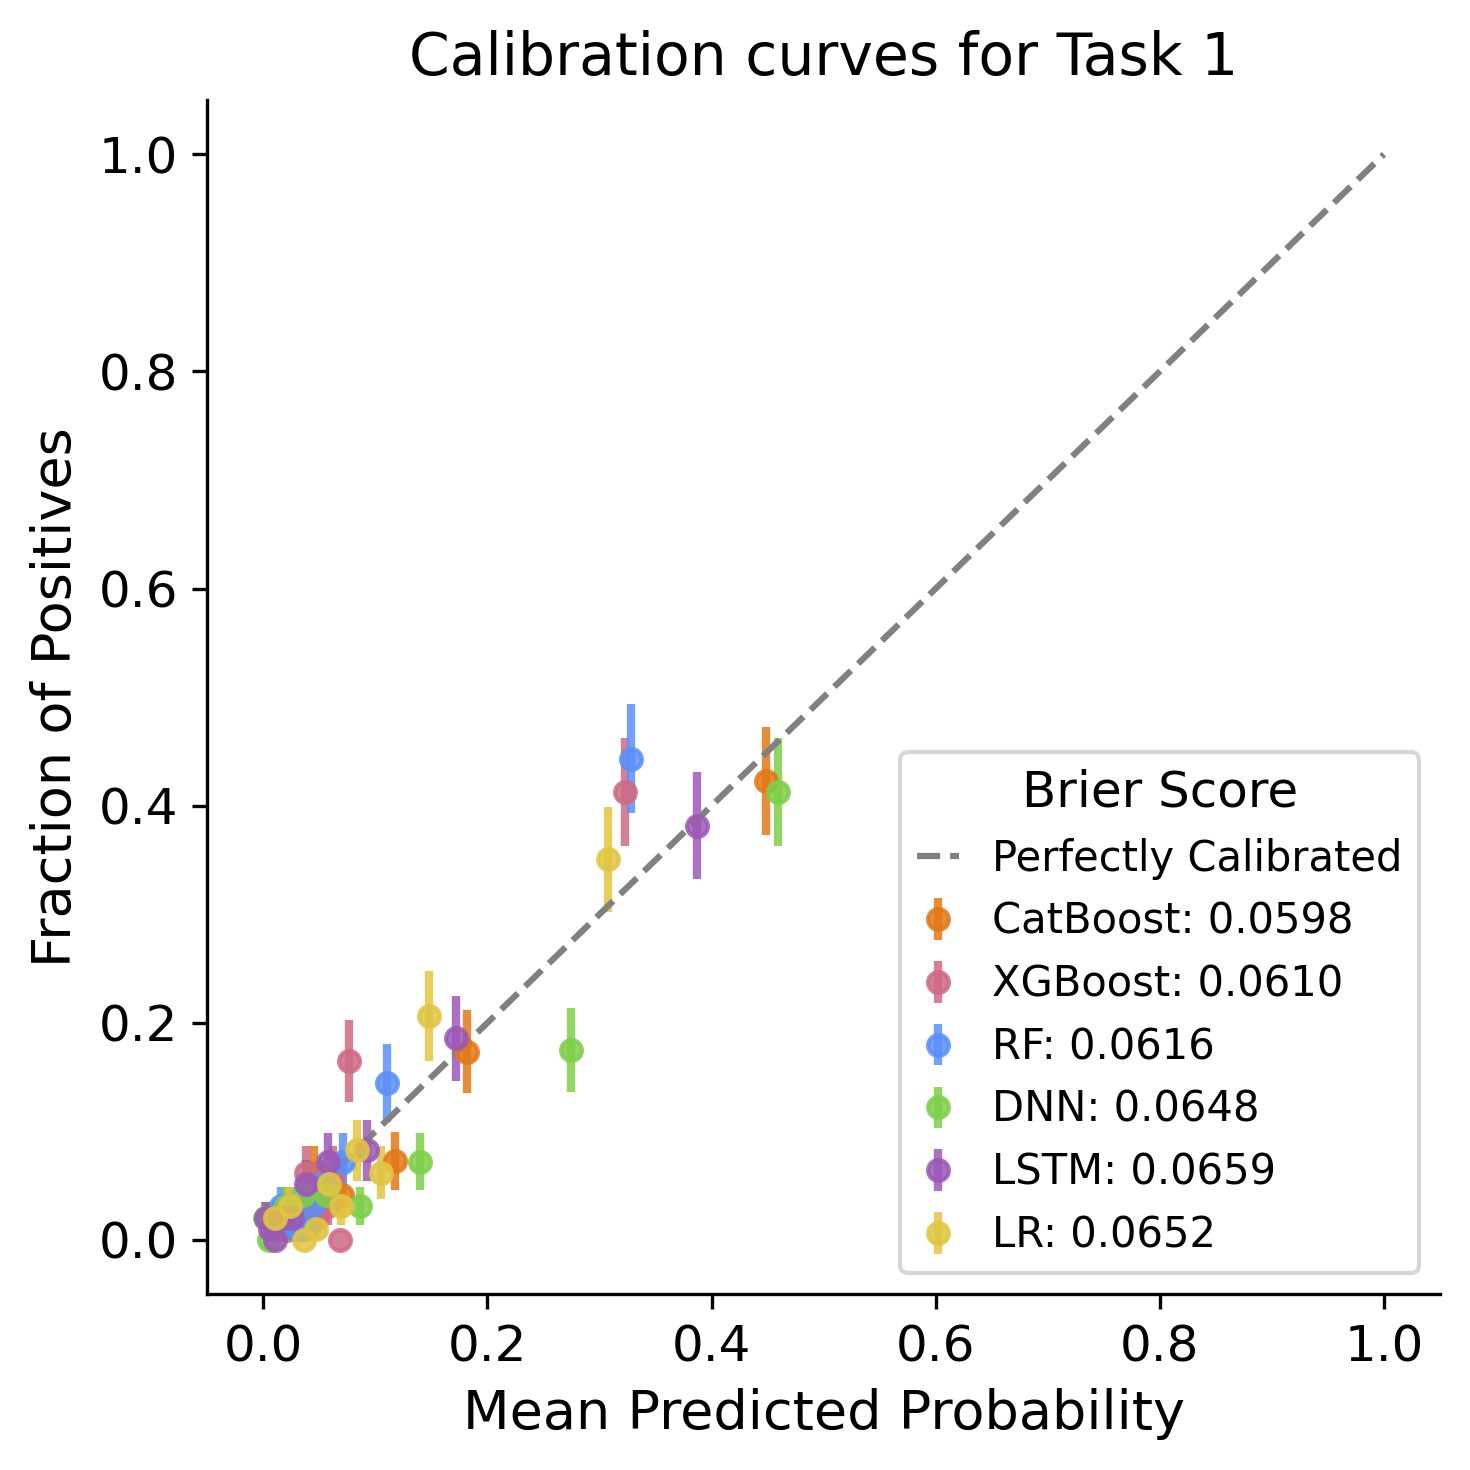

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KernelDensity
import os

# ============================================
# Adaptive Quantile Binning (Fixed Version: Added Sorting)
# ============================================
def adaptive_binning(y_true, y_prob, n_bins=10, method='quantile'):
    if method == 'quantile':
        bins = np.percentile(y_prob, np.linspace(0, 100, n_bins + 1))
    elif method == 'density':
        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(y_prob[:, None])
        bins = np.linspace(0, 1, n_bins + 1)
    else:
        raise ValueError("Method should be 'quantile' or 'density'")

    bin_indices = np.digitize(y_prob, bins) - 1
    fraction_of_positives = []
    mean_predicted_value = []
    std_errors = []

    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            fraction_of_positives.append(np.mean(y_true[mask]))
            mean_predicted_value.append(np.mean(y_prob[mask]))
            std_errors.append(np.std(y_true[mask]) / np.sqrt(np.sum(mask)))
    # ----------------------------
    # Key Fix: Sort by mean_pred
    # ----------------------------
    fraction_of_positives = np.array(fraction_of_positives)
    mean_predicted_value = np.array(mean_predicted_value)
    std_errors = np.array(std_errors)
    order = np.argsort(mean_predicted_value)
    return (
        fraction_of_positives[order],
        mean_predicted_value[order],
        std_errors[order],
        bins
    )

# ============================================
# Brier Score (Correct, No Modification Needed)
# ============================================
def brier_score(y_true, y_prob):
    return np.mean((y_true - y_prob)**2)

# ============================================
# Model List (Fully Consistent with DCA)
# ============================================
models = [
    'catboost',
    'xgboost',
    'randomforest',
    'DNN',
    'LSTM',
    'lr',
]

labels = [
    'CatBoost',
    'XGBoost',
    'RF',
    'DNN',
    'LSTM',
    'LR',
]

# Colors (Same as Your DCA Color Scheme)
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6", "#E1C542"]
data = {}

# ============================================
# Load Prediction Files (Fully Synchronized with DCA)
# ============================================
for model in models:

    # if model == 'DNN':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'all_folds_results.csv')
    # elif model == 'LSTM':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_death_valid_test_5cv', 'seed_1251_all_results.csv')
    # elif model == 'catboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## Random seed during training
    # elif model == 'xgboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## Random seed during training
    # elif model == 'randomforest':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_gridsearch_valid_test_5cv'
    #     file = os.path.join(search_path, f'max_depth_5_n_estimators_200', 'all_folds_results.csv')
    # elif model == 'lr':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death/{model}_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')

    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_calibration', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_death_calibration', 'all_folds_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## Random seed during training
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## Random seed during training
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue

    df = pd.read_csv(file)
    print(f"✅ Read {model} file: {file} with {len(df)} records")
    data[model] = df

# ============================================
# Plot Calibration Curve (Consistent with DCA Style)
# ============================================
plt.figure(figsize=(5, 5), dpi=300)

for idx, (model, label) in enumerate(zip(models, labels)):
    if model not in data:
        continue
    y_test = data[model]['y_test'].values
    y_pred = data[model]['y_pred'].values
    frac_pos, mean_pred, std_err, bins = adaptive_binning(y_test, y_pred, n_bins=10)
    brier = brier_score(y_test, y_pred)
    plt.errorbar(
        mean_pred,
        frac_pos,
        yerr=std_err,
        fmt='.',
        label=f"{label}: {brier:.4f}",
        # markersize=6,
        # elinewidth=1,
        markersize=10,
        elinewidth=2,
        alpha=0.85,
        color=colors[idx]
    )

# plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel("Mean Predicted Probability", fontsize=13)
plt.ylabel("Fraction of Positives", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Calibration curves for Task 1", fontsize=14)

lg = plt.legend(
    loc='lower right',
    handlelength=1.0,
    fontsize=10,
    title="Brier Score",
)
lg.get_title().set_fontsize(12)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## Cohort 2 (Recovery vs. Non-recovery)

✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/catboost_fixed_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/xgboost_fixed_valid_test_5cv/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/randomforest_fixed_valid_test_5cv/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_non-recovery_valid_test_5cv/seed_5628/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_non-recovery_valid_test_5cv/seed_7567/seed_7567_all_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/lr_valid_test_5cv/all_folds_results.csv，共 971 条记录


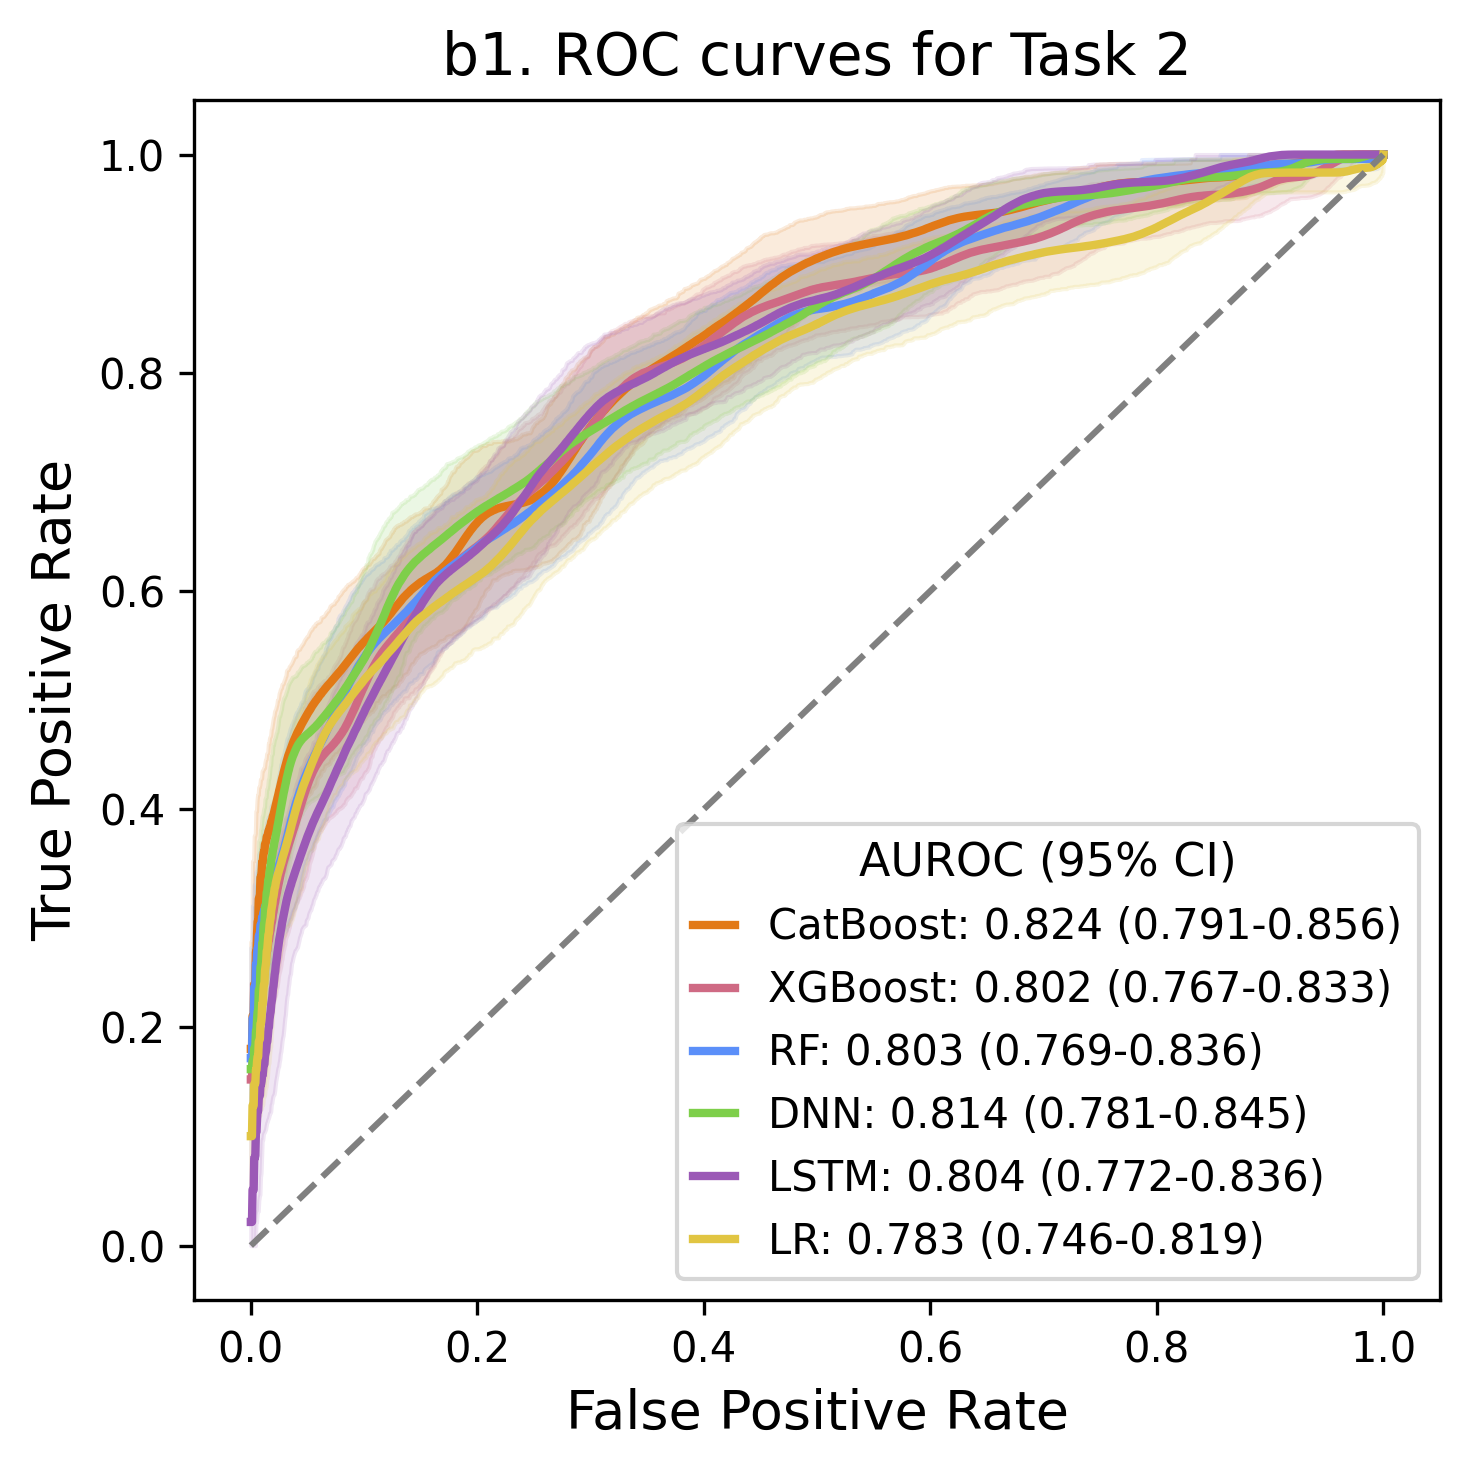

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

title_num = 'b1'

# =========================================================
# Calculate ROC curve + confidence interval
# =========================================================
def get_roc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_fpr = np.linspace(0, 1, 2000)

    bootstrapped_scores = []
    tprs = []

    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]

        fpr, tpr, _ = roc_curve(y_true_boot, y_pred_boot)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        bootstrapped_scores.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    mean_auc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)
    return mean_fpr, mean_tpr, tprs_lower, tprs_upper, mean_auc, ci_lower, ci_upper

# =========================================================
# Parameter definitions
# =========================================================
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]  # Color for each model
models = [
          'catboost',
          'xgboost',
          'randomforest',
          'DNN',
          'LSTM',
          'lr',
          ]
labels = [
          'CatBoost',
          'XGBoost',
          'RF',
          'DNN', 
          'LSTM',
          'LR',
          ]

# =========================================================
# Plot ROC curve
# =========================================================
plt.figure(figsize=(5, 5), dpi=300)
# plt.figure(figsize=(5, 5))

for model, color, label in zip(models, colors, labels):
    # file = os.path.join(search_path, model, 'predict_death_valid_test', 'all_folds_results.csv')
    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv','seed_5628', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv', 'seed_7567','seed_7567_all_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv') 
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv')
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue

    df = pd.read_csv(file)
    print(f"✅ File read: {file}, total {len(df)} records")
    if not {'y_test', 'y_pred'}.issubset(df.columns):
        raise ValueError(f"{file} is missing 'y_test' or 'y_pred' columns")

    # Calculate ROC + CI
    mean_fpr, mean_tpr, tprs_lower, tprs_upper, mean_auc, ci_lower, ci_upper = get_roc_CI_curve(
        df['y_test'], df['y_pred']
    )

    # Plot
    plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
             label=f"{label}: {mean_auc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=0.15)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

lg = plt.legend(loc='lower right', handlelength=1.0, fontsize=10, title='AUROC (95% CI)')
lg.get_title().set_fontsize(11)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title(f'{title_num}. ROC curves for Task 2', fontsize=14)
plt.tight_layout()
plt.show()


✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/catboost_fixed_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/xgboost_fixed_valid_test_5cv/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/randomforest_fixed_valid_test_5cv/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_non-recovery_valid_test_5cv/seed_5628/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_non-recovery_valid_test_5cv/seed_7567/seed_7567_all_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/lr_valid_test_5cv/all_folds_results.csv，共 971 条记录


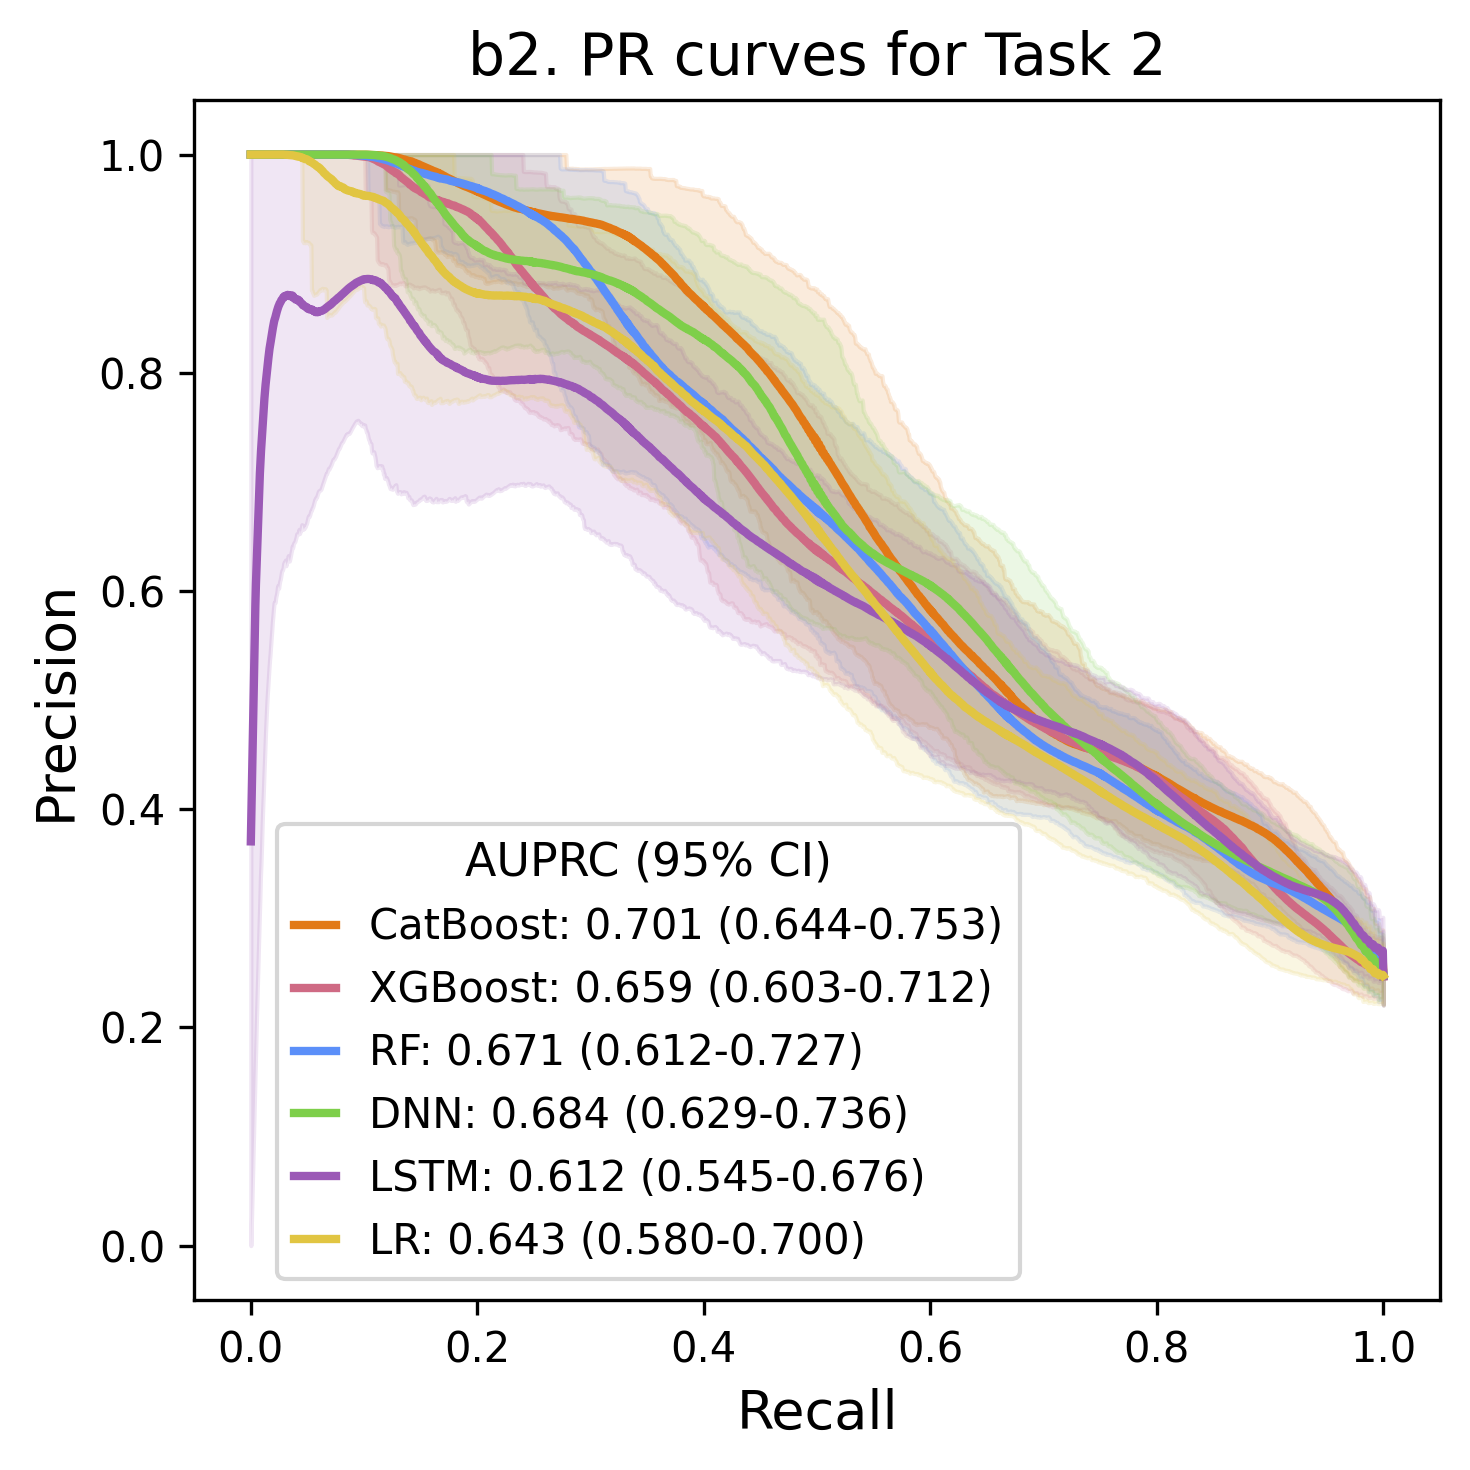

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

title_num = 'b2'

# =========================================================
# Calculate PRC + Confidence Interval
# =========================================================
def get_prc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_recall = np.linspace(0, 1, 2000)
    bootstrapped_scores = []
    precisions = []
    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]
        precision, recall, _ = precision_recall_curve(y_true_boot, y_pred_boot)
        # Interpolate precision at the same recall
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        bootstrapped_scores.append(average_precision_score(y_true_boot, y_pred_boot))
    mean_precision = np.mean(precisions, axis=0)
    precisions_lower = np.percentile(precisions, 2.5, axis=0)
    precisions_upper = np.percentile(precisions, 97.5, axis=0)
    mean_auprc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)
    return mean_recall, mean_precision, precisions_lower, precisions_upper, mean_auprc, ci_lower, ci_upper

# =========================================================
# Parameter Definitions
# =========================================================
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]
models = [
          'catboost',
          'xgboost',
          'randomforest',
          'DNN',
          'LSTM',
          'lr',
          ]
labels = [
          'CatBoost',
          'XGBoost',
          'RF',
          'DNN', 
          'LSTM',
          'LR',
          ]

# =========================================================
# Plot PRC Curves
# =========================================================
# plt.figure(figsize=(5, 5))
plt.figure(figsize=(5, 5), dpi=300)

for model, color, label in zip(models, colors, labels):
    # file = os.path.join(search_path, model, 'predict_death_valid_test', 'all_folds_results.csv')
    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv','seed_5628', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv', 'seed_7567','seed_7567_all_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## Random seed during model training
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## Random seed during model training
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_valid_test_5cv'
        file = os.path.join(search_path, 'all_folds_results.csv')
    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue
    df = pd.read_csv(file)
    print(f"✅ File read: {file}, total {len(df)} records")
    if not {'y_test', 'y_pred'}.issubset(df.columns):
        raise ValueError(f"{file} is missing 'y_test' or 'y_pred' columns")
    # Calculate PRC + CI
    mean_recall, mean_precision, precisions_lower, precisions_upper, mean_auprc, ci_lower, ci_upper = get_prc_CI_curve(
        df['y_test'], df['y_pred'])
    # Plot
    plt.plot(mean_recall, mean_precision, color=color, lw=2,
             label=f"{label}: {mean_auprc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})")
    plt.fill_between(mean_recall, precisions_lower, precisions_upper, color=color, alpha=0.15)

# plt.plot([0, 1], [0.5, 0.5], color='gray', linestyle='--', label='Baseline (0.5)')

lg = plt.legend(
    loc='lower left',
    bbox_to_anchor=(0.05, 0.0),
    handlelength=1.0,
    fontsize=10,
    title='AUPRC (95% CI)'
)
lg.get_title().set_fontsize(11)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title(f'{title_num}. PR curves for Task 2', fontsize=14)
plt.tight_layout()
plt.show()


✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/xgboost/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/randomforest/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/DNN/predict_non-recovery_calibration/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/LSTM/predict_non-recovery_calibration/all_folds_results.csv，共 971 条记录
✅ 读取文件：/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/lr/all_folds_results.csv，共 971 条记录


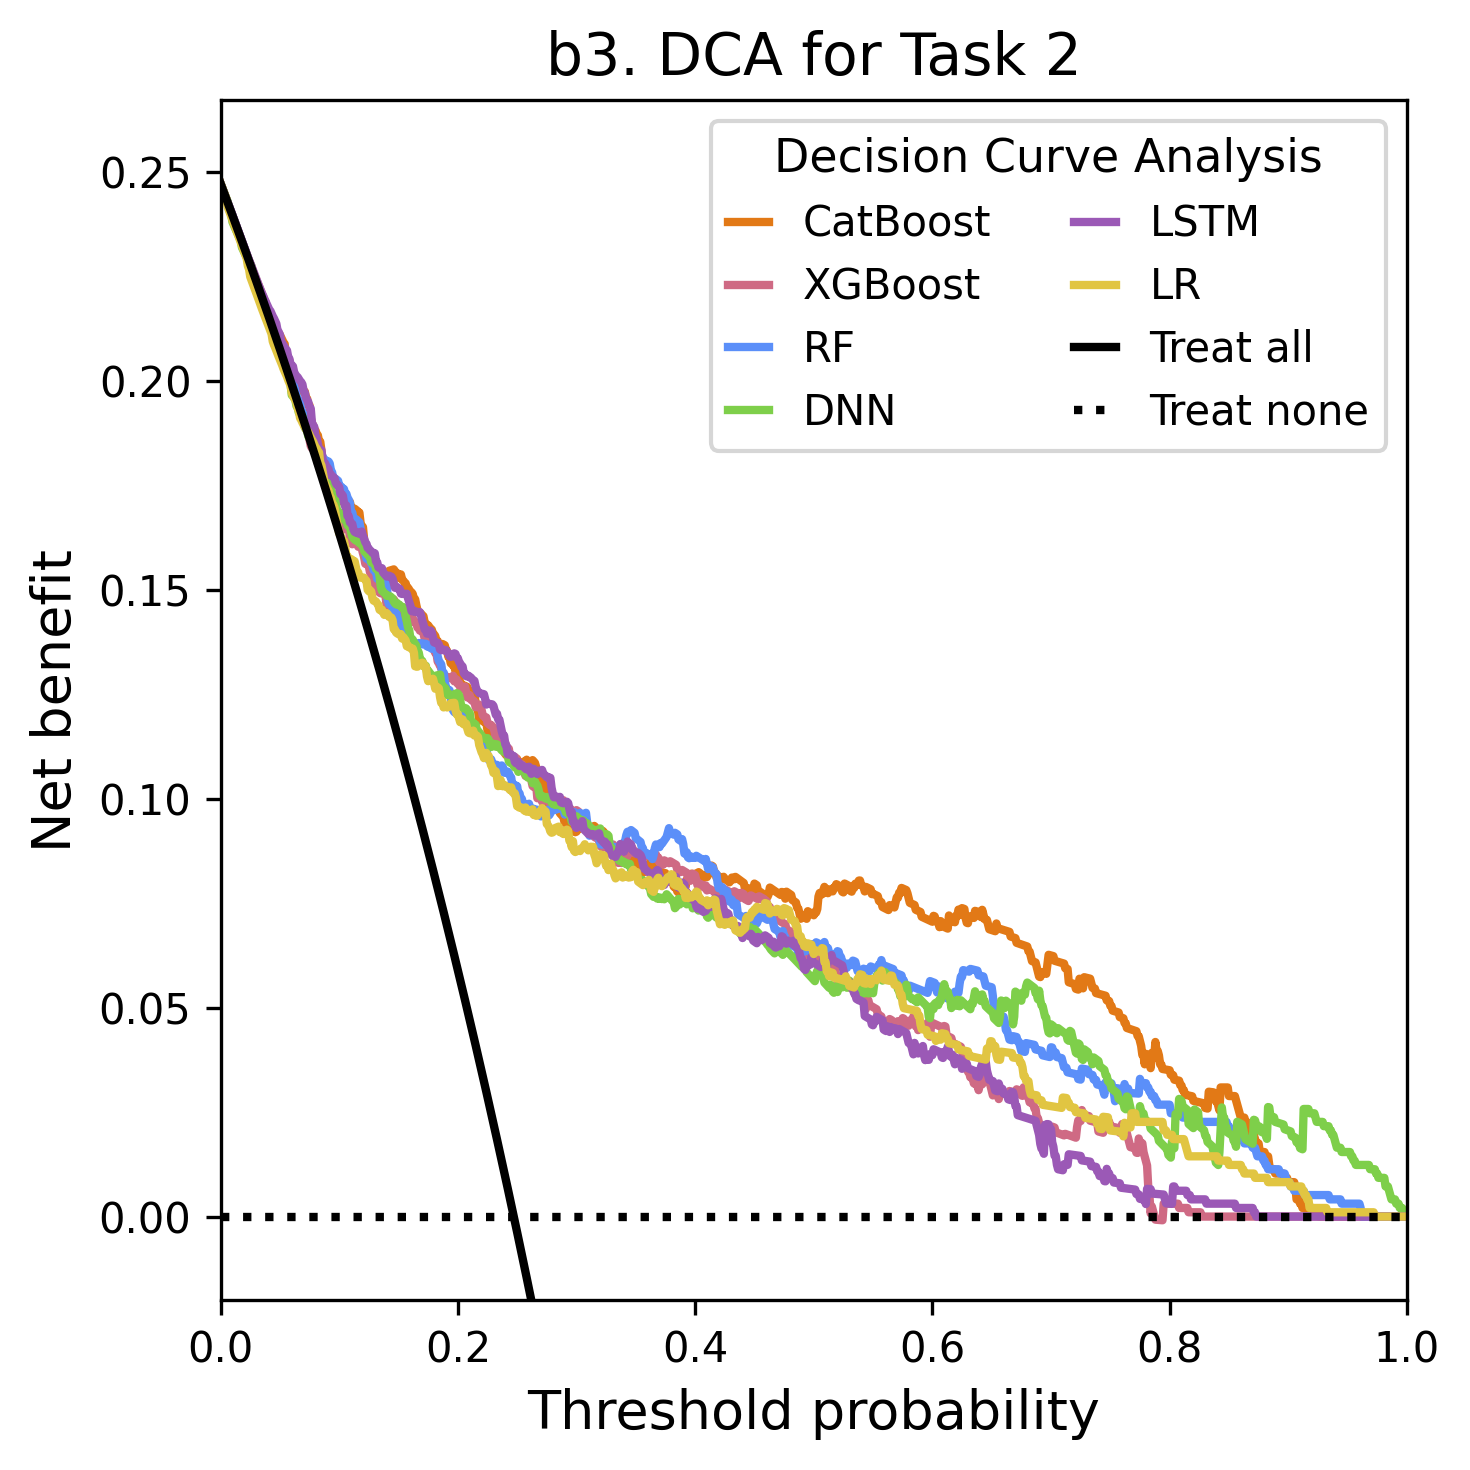

In [ ]:
#####################################
# Decision Analysis Curve (DCA)
#####################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
# import matplotlib
# matplotlib.use('TkAgg')

######################
## decision_curve
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

#########

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

title_num = 'b3'

data = {}
thresh_group = np.arange(0, 1, 0.001)
plt.figure(figsize=(5, 5), dpi=300)

models = [
    'catboost',
    'xgboost',
    'randomforest',
    'DNN',
    'LSTM',
    'lr',
]
labels = [
    'CatBoost',
    'XGBoost',
    'RF',
    'DNN', 
    'LSTM',
    'LR',
]

colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6","#E1C542"]

for model in models:
    # if model == 'DNN':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv','seed_5628', 'all_folds_results.csv')
    # elif model == 'LSTM':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/'
    #     file = os.path.join(search_path, model, 'predict_non-recovery_valid_test_5cv', 'seed_7567','seed_7567_all_results.csv')
    # elif model == 'catboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## 训练模型时试随机种子
    # elif model == 'xgboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## 训练模型时试随机种子
    # elif model == 'randomforest':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')
    # elif model == 'lr':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')

    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_calibration', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_calibration', 'all_folds_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')  ## 训练模型时试随机种子
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv') ## 训练模型时试随机种子
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ File not found: {file}")
        continue
    df = pd.read_csv(file)
    print(f"✅ File read successfully: {file}, total {len(df)} records")
    data[model] = df

# Plot the DCA curve
for c_index, (model, label) in enumerate(zip(models, labels)):
    if model not in data:
        continue
    net_benefit_model = calculate_net_benefit_model(
        thresh_group, 
        data[model]['y_pred'],
        data[model]['y_test']
    )
    plt.plot(
        thresh_group, 
        net_benefit_model, 
        label=label,
        color=colors[c_index], 
        lw=2
    )

net_benefit_all = calculate_net_benefit_all(thresh_group, data[model]['y_test'])
plt.plot(thresh_group, net_benefit_all, color='black', lw=2, label='Treat all')
plt.plot((0, 1), (0, 0), color='black', linestyle=':', lw=2, label='Treat none')

plt.xlim(0, 1)
plt.ylim(net_benefit_model.min() - 0.02, net_benefit_model.max() + 0.02)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.xlabel('Threshold probability', fontsize=13)
plt.ylabel('Net benefit', fontsize=13)
# plt.legend(loc='upper right', handlelength=1.0, fontsize=10, title='Decision Curve')
# plt.legend(loc='upper right', handlelength=1.0, fontsize=10)
lg = plt.legend(
    loc='upper right',
    handlelength=1.0,
    fontsize=10,
    ncol=2,
    columnspacing=2.0,
    title='Decision Curve Analysis',
)
lg.get_title().set_fontsize(11)

plt.title(
    f'{title_num}. DCA for Task 2',
    fontsize=14
)
plt.tight_layout()
plt.show()


✅ 读取 catboost 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv 共 971 条记录
✅ 读取 xgboost 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/xgboost/learning_rate_0.05_max_depth_5_n_estimators_200/all_folds_results.csv 共 971 条记录
✅ 读取 randomforest 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/randomforest/all_folds_results.csv 共 971 条记录
✅ 读取 DNN 文件: /home/mailiyi/Poisoning_Prediction/DNN/predict_non-recovery_calibration/all_folds_results.csv 共 971 条记录
✅ 读取 LSTM 文件: /home/mailiyi/Poisoning_Prediction/LSTM/predict_non-recovery_calibration/all_folds_results.csv 共 971 条记录
✅ 读取 lr 文件: /home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/lr/all_folds_results.csv 共 971 条记录


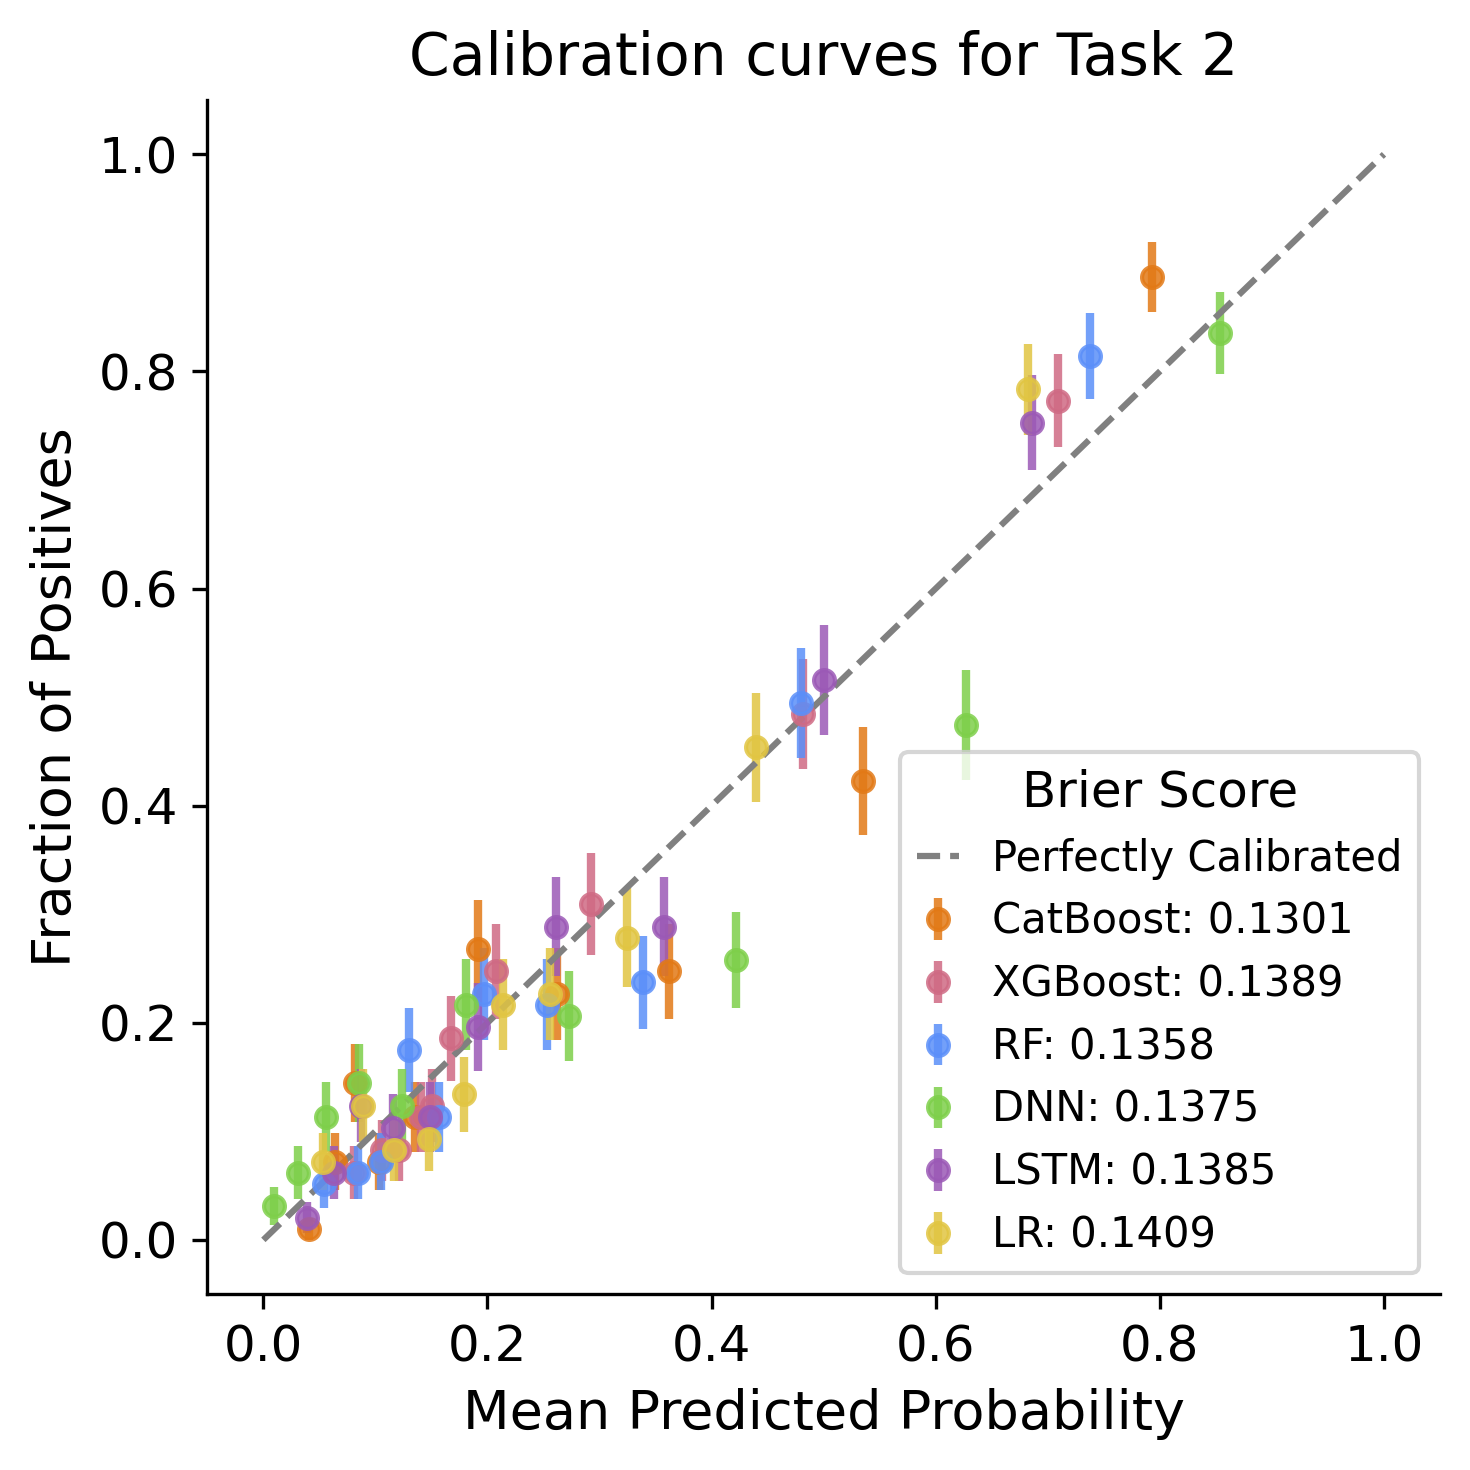

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KernelDensity
import os

# ============================================
# Adaptive Quantile Binning (Fixed Version: Add Sort)
# ============================================
def adaptive_binning(y_true, y_prob, n_bins=10, method='quantile'):
    if method == 'quantile':
        bins = np.percentile(y_prob, np.linspace(0, 100, n_bins + 1))
    elif method == 'density':
        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(y_prob[:, None])
        bins = np.linspace(0, 1, n_bins + 1)
    else:
        raise ValueError("Method should be 'quantile' or 'density'")

    bin_indices = np.digitize(y_prob, bins) - 1
    fraction_of_positives = []
    mean_predicted_value = []
    std_errors = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            fraction_of_positives.append(np.mean(y_true[mask]))
            mean_predicted_value.append(np.mean(y_prob[mask]))
            std_errors.append(np.std(y_true[mask]) / np.sqrt(np.sum(mask)))

    # ----------------------------
    # Key fixes: sort by mean_pred!
    # ----------------------------
    fraction_of_positives = np.array(fraction_of_positives)
    mean_predicted_value = np.array(mean_predicted_value)
    std_errors = np.array(std_errors)

    order = np.argsort(mean_predicted_value)
    return (
        fraction_of_positives[order],
        mean_predicted_value[order],
        std_errors[order],
        bins
    )

# ============================================
# Brier Score (correct, no modification required)
# ============================================
def brier_score(y_true, y_prob):
    return np.mean((y_true - y_prob)**2)

# ============================================
# List of models (fully consistent with DCA)
# ============================================
models = [
    'catboost',
    'xgboost',
    'randomforest',
    'DNN',
    'LSTM',
    'lr',
]
labels = [
    'CatBoost',
    'XGBoost',
    'RF',
    'DNN',
    'LSTM',
    'LR',
]

# Color (use your DCA color scheme)
colors = ["#E27916", "#CF6A84", "#5B8FF9", "#7ECF4A", "#9B59B6", "#E1C542"]
data = {}

# ============================================
# Load prediction files (fully synchronized with your DCA)
# ============================================
for model in models:

    # if model == 'DNN':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/{model}/predict_non-recovery_valid_test_5cv/seed_5628'
    #     file = os.path.join(search_path, 'all_folds_results.csv')
    # elif model == 'LSTM':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/{model}/predict_non-recovery_valid_test_5cv/seed_7567'
    #     file = os.path.join(search_path, 'seed_7567_all_results.csv')
    # elif model == 'catboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, 'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')
    # elif model == 'xgboost':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, 'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv')
    # elif model == 'randomforest':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_fixed_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')
    # elif model == 'lr':
    #     search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/{model}_valid_test_5cv'
    #     file = os.path.join(search_path, 'all_folds_results.csv')

    if model == 'DNN':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_calibration', 'all_folds_results.csv')
    elif model == 'LSTM':
        search_path = f'/home/mailiyi/Poisoning_Prediction/'
        file = os.path.join(search_path, model, 'predict_non-recovery_calibration', 'all_folds_results.csv')
    elif model == 'catboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, f'depth_5_iterations_200_learning_rate_0.05', 'all_folds_results.csv')
    elif model == 'xgboost':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, f'learning_rate_0.05_max_depth_5_n_estimators_200', 'all_folds_results.csv')
    elif model == 'randomforest':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')
    elif model == 'lr':
        search_path = f'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/{model}/'
        file = os.path.join(search_path, 'all_folds_results.csv')

    if not os.path.exists(file):
        print(f"⚠️ file not found：{file}")
        continue
    df = pd.read_csv(file)
    print(f"✅ Read {model} file: {file} total {len(df)} records")
    data[model] = df

# ============================================
# Draw calibration curve (consistent with DCA style)
# ============================================
plt.figure(figsize=(5, 5), dpi=300)

for idx, (model, label) in enumerate(zip(models, labels)):
    if model not in data:
        continue
    y_test = data[model]['y_test'].values
    y_pred = data[model]['y_pred'].values
    frac_pos, mean_pred, std_err, bins = adaptive_binning(y_test, y_pred, n_bins=10)
    brier = brier_score(y_test, y_pred)
    plt.errorbar(
        mean_pred,
        frac_pos,
        yerr=std_err,
        fmt='.',
        label=f"{label}: {brier:.4f}",
        # markersize=6,
        # elinewidth=1,
        markersize=10,
        elinewidth=2,
        alpha=0.85,
        color=colors[idx]
    )

# plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel("Mean Predicted Probability", fontsize=13)
plt.ylabel("Fraction of Positives", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Calibration curves for Task 2", fontsize=14)

lg = plt.legend(
    loc='lower right',
    handlelength=1.0,
    fontsize=10,
    title="Brier Score",
)
lg.get_title().set_fontsize(12)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



In [67]:
print(data['catboost']['y_pred'].describe())

count    971.000000
mean       0.257655
std        0.234503
min        0.021065
25%        0.080970
50%        0.156112
75%        0.358179
max        0.925024
Name: y_pred, dtype: float64


In [68]:
print(data['xgboost']['y_pred'].describe())

count    971.000000
mean       0.246322
std        0.194054
min        0.072315
25%        0.119940
50%        0.156512
75%        0.289097
max        0.826015
Name: y_pred, dtype: float64
